<a href="https://colab.research.google.com/github/rkambai/ImageClassification-DoomCrossing/blob/main/memes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/doomcrossing/")

In [3]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory

import PIL.Image as Image

import matplotlib.pyplot as plt

### Upload train and test data

In [4]:
data_dir = '/content/drive/MyDrive/doomcrossing/'
IMAGE_SHAPE = (224,224)
batch_size = 16

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMAGE_SHAPE,
  batch_size=batch_size)

Found 1597 files belonging to 2 classes.
Using 1278 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMAGE_SHAPE,
  batch_size=batch_size)

Found 1597 files belonging to 2 classes.
Using 319 files for validation.


### Print class names

In [6]:
class_names = train_ds.class_names
print(class_names)

['animal_crossing', 'doom']


### Show first 9 entries and labels

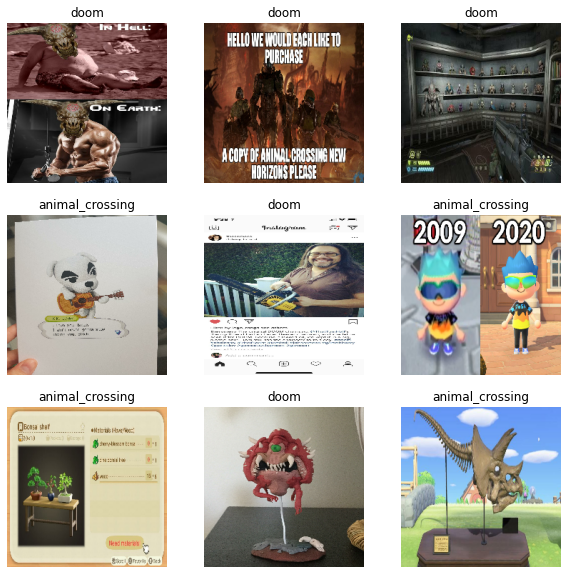

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Add preprocessing layers

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [9]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

### Import headless model

In [10]:
IMG_SHAPE = IMAGE_SHAPE + (3,)
feature_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(
    feature_model,
    input_shape=IMG_SHAPE,
    trainable=False ## freezes layers with its pretrained weights)

### Create and train the model

In [11]:
num_classes = 2
model = tf.keras.Sequential([
    normalization_layer,
    data_augmentation,
    feature_extractor_layer,
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes) # changing top layer
])

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [13]:
learning_rate = 0.0001
epochs=10
model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
80/80 [==============================] - 300s 4s/step - loss: 0.5251 - accuracy: 0.7433 - val_loss: 0.4024 - val_accuracy: 0.8119
Epoch 2/10
80/80 [==============================] - 84s 1s/step - loss: 0.3756 - accuracy: 0.8247 - val_loss: 0.3731 - val_accuracy: 0.8339
Epoch 3/10
80/80 [==============================] - 83s 1s/step - loss: 0.3378 - accuracy: 0.8521 - val_loss: 0.3904 - val_accuracy: 0.8056
Epoch 4/10
80/80 [==============================] - 84s 1s/step - loss: 0.3008 - accuracy: 0.8646 - val_loss: 0.3407 - val_accuracy: 0.8370
Epoch 5/10
80/80 [==============================] - 83s 1s/step - loss: 0.2886 - accuracy: 0.8732 - val_loss: 0.3431 - val_accuracy: 0.8621
Epoch 6/10
80/80 [==============================] - 83s 1s/step - loss: 0.3049 - accuracy: 0.8740 - val_loss: 0.3430 - val_accuracy: 0.8558
Epoch 7/10
80/80 [==============================] - 83s 1s/step - loss: 0.2809 - accuracy: 0.8818 - val_loss: 0.3523 - val_accuracy: 0.8527
Epoch 8/10
80/80 [=

In [14]:
image_batch, label_batch = val_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

In [15]:
image_batch.shape

(16, 224, 224, 3)

In [16]:
label_batch.shape

(16,)

### Predict on test batch

In [26]:
pred = []
for i in predictions:
  pred.append(np.argmax(i))

Predictions:
 [1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
Labels:
 [1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]


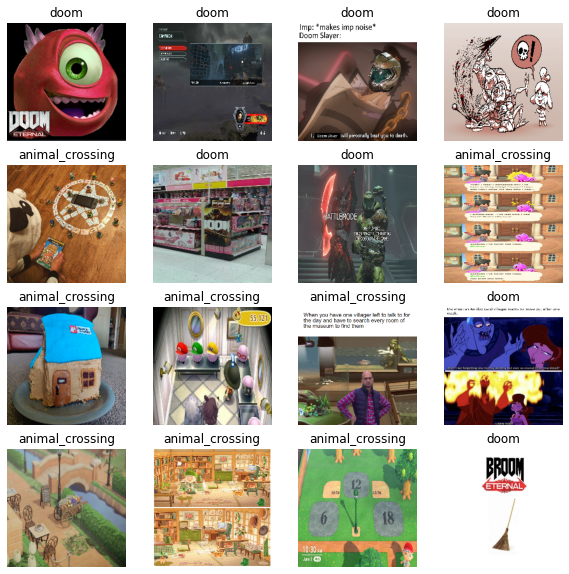

In [40]:
print('Predictions:\n', pred)
print('Labels:\n', list(label_batch))

plt.figure(figsize=(10, 10))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[pred[i]])
  plt.axis("off")

### We see that this model classified 15/16 of the memes correctly, with the wrongly classified one being the following:
 - understandable as the image given looks rather dark with somewhat doomy vibes

Text(0.5, 1.0, 'predicted: doom\n actual: animal_crossing')

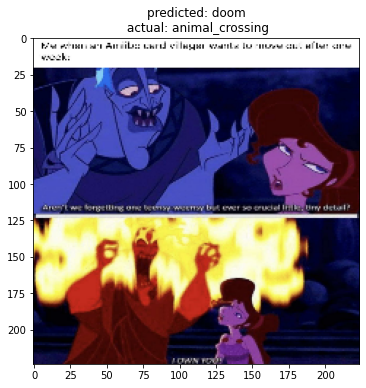

In [57]:
plt.figure(figsize=(6,6))
plt.imshow(image_batch[11].astype("uint8"))
plt.title("predicted: "+class_names[pred[11]]+"\n"+" actual: "+class_names[label_batch[11]])
